In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from glob import glob
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
os.chdir(r'/storage/users/g-and-n/visual_models_results')

In [ ]:
def extract_final_results(model, reload_df=False):
    os.makedirs(f'final_results/{model}/errors', exist_ok=True)
    
    if reload_df:
        for j in tqdm(range(1, 36)):
            exist = False

            dfs = []
            for i, chan in enumerate(['AGP', 'DNA', 'ER', 'Mito', 'RNA']):
                chan_num = (i+1)*100

                csv_path = fr'{chan_num+j}/{model}/channel {chan}/results.csv'

                df = pd.read_csv(csv_path, index_col=list(range(6))).rename({'PCC':f'{chan}_PCC','MSE':f'{chan}_MSE'}, axis=1) 
                dfs.append(df)

            df = pd.concat(dfs, axis=1)
            plate_num = df.index.get_level_values(0).unique().to_list()
            if len(plate_num) != 1:
                raise 'Not one plate per experiment'

            plate_num = plate_num[0]
            df.to_csv(fr'final_results/{model}/errors/{plate_num}.csv')
            del df
    
    csvs_path = glob(fr'final_results/{model}/errors/*.csv')
    csvs = {os.path.basename(csv_path): pd.read_csv(csv_path, index_col=list(range(6))) for csv_path in csvs_path}
    return csvs

models_csvs = {model: extract_final_results(model, False) for model in ['AUTO1T01', 'UNET4TO1']}        
    

In [ ]:
[len(j) for i,j in models_csvs.items()]

In [ ]:
def extract_zscores_visual(vis_res_path, p):
    os.makedirs(fr'{vis_res_path}/zscores', exist_ok=True)
    zscore_path = fr'{vis_res_path}/zscores/{p}'
    if os.path.exists(zscore_path):
        return pd.read_csv(zscore_path, index_col=list(range(4)))
    
    
    df = pd.read_csv(fr'{vis_res_path}/errors/{p}', index_col=list(range(6)))

    df = df.groupby(['Plate','Well_Role','Well','Broad_Sample']).mean()

    pcc_all = df.filter(regex='_PCC', axis=1).mean(axis=1)
    pcc_all.name = 'ALL_PCC'
    mse_all = df.filter(regex='_MSE', axis=1).mean(axis=1)
    mse_all.name = 'ALL_MSE'

    df = pd.concat([df,pcc_all,mse_all], axis=1)

    df_mock = df.query('Well_Role == "mock"')
    scaler = StandardScaler()
    scaler.fit(df_mock)
    del df_mock

    df_zscores = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    del df
    df_zscores.to_csv(zscore_path)
    
    return df_zscores

In [ ]:
res = {model: [extract_zscores_visual(fr'final_results/{model}', p) for p in os.listdir(fr'final_results/{model}/errors')] for model in ['AUTO1T01', 'UNET4TO1']}

In [ ]:
res = {k: pd.concat(csvs) for k, csvs in res.items()}

## Load new results

In [3]:
models = [m for m in os.listdir(r'./30000') if m not in ['results', 'plots']]

In [4]:
res={m: pd.concat([pd.read_csv(pth, index_col=[0,1,2,3]) for pth in glob(f'./30000/results/z_scores/{m}/*.csv')]) for m in models}

In [5]:
res = {m: df.add_suffix(f'_{m}') for m, df in res.items()}

In [6]:
f_res = pd.concat(res.values(), axis=1)

In [7]:
f_trt = f_res.query('Well_Role != "mock"')
f_trt.index = f_trt.index.droplevel([1,3])
f_trt.shape

(126499, 72)

In [8]:
f_trt = f_trt[~f_trt.index.isin([26576,25732,25742,25740,25741,25739],level=0)]
f_trt.shape

(125947, 72)

In [9]:
f_trt

RNA_PCC_UNET4TO1  RNA_MSE_UNET4TO1  \
Plate Broad_Sample                                                 
24277 BRD-K18250272-003-03-7         -2.727975         -0.164039   
      BRD-K18316707-001-01-9         -4.323357          1.110768   
      BRD-K18438502-001-02-6         -4.846370          0.410155   
      BRD-K18550767-001-02-8          1.387897         -1.104021   
      BRD-K18574842-323-03-3          1.168869         -0.827136   
...                                        ...               ...   
26795 BRD-K98110717-001-01-7          0.164304         -0.720820   
      BRD-K98427581-001-01-8          0.709274          3.201042   
      BRD-K98538413-001-01-6         -0.313273         -0.718054   
      BRD-K98758861-001-01-7         -1.103223          3.085965   
      BRD-K99216703-001-01-7         -1.062129         -0.755900   

                              Mito_PCC_UNET4TO1  Mito_MSE_UNET4TO1  \
Plate Broad_Sample                                                   
24277 BRD-K18250272-003-03-7          -3.755993           2.300662   
      BRD-K18316707-001-01-9          -4.320225           6.001358   
      BRD-K18438502-001-02-6          -3.231647           2.390175   
      BRD-K18550767-001-02-8          -2.272553           0.145992   
      BRD-K18574842-323-03-3          -2.227684           0.540267   
...                                         ...                ...   
26795 BRD-K98110717-001-01-7          -0.046189          -0.509283   
      BRD-K98427581-001-01-8          -0.239717           0.842233   
      BRD-K98538413-001-01-6          -1.900684           8.004043   
      BRD-K98758861-001-01-7          -0.414712          -0.466143   
      BRD-K99216703-001-01-7          -0.888124           0.351235   

                              ER_PCC_UNET4TO1  ER_MSE_UNET4TO1  \
Plate Broad_Sample                                               
24277 BRD-K18250272-003-03-7        -4.322570         0.156072   
      BRD-K18316707-001-01-9        -6.278044         0.535738   
      BRD-K18438502-001-02-6        -4.246852        -0.146696   
      BRD-K18550767-001-02-8        -0.298984        -1.068980   
      BRD-K18574842-323-03-3         0.530880        -0.710329   
...                                       ...              ...   
26795 BRD-K98110717-001-01-7         0.339227        -0.539680   
      BRD-K98427581-001-01-8         0.803297        -0.871135   
      BRD-K98538413-001-01-6        -0.240232         0.039753   
      BRD-K98758861-001-01-7        -0.024924        -0.637073   
      BRD-K99216703-001-01-7         1.190367        -0.665345   

                              DNA_PCC_UNET4TO1  DNA_MSE_UNET4TO1  \
Plate Broad_Sample                                                 
24277 BRD-K18250272-003-03-7         -2.197965         -0.132914   
      BRD-K18316707-001-01-9         -0.536085         -0.287553   
      BRD-K18438502-001-02-6          0.313964         -0.426654   
      BRD-K18550767-001-02-8          0.355100         -0.448438   
      BRD-K18574842-323-03-3          0.631544         -0.415083   
...                                        ...               ...   
26795 BRD-K98110717-001-01-7         -0.325270          1.777610   
      BRD-K98427581-001-01-8          0.403835          0.171332   
      BRD-K98538413-001-01-6         -0.534776          0.219408   
      BRD-K98758861-001-01-7         -0.565230         -0.056553   
      BRD-K99216703-001-01-7         -0.017793         -0.057736   

                              AGP_PCC_UNET4TO1  AGP_MSE_UNET4TO1  ...  \
Plate Broad_Sample                                                ...   
24277 BRD-K18250272-003-03-7         -3.910304          0.697684  ...   
      BRD-K18316707-001-01-9         -6.912486          1.293183  ...   
      BRD-K18438502-001-02-6         -4.006004          0.448897  ...   
      BRD-K18550767-001-02-8          0.485393         -1.264027  ...   
      BRD-K18574842-323-03-3          0.523020      

In [15]:
cols=f_trt.filter(regex='ALL_MSE', axis=1).columns
cols

Index(['ALL_MSE_UNET4TO1', 'ALL_MSE_UNET1TO1', 'ALL_MSE_AUTO1TO1',
       'ALL_MSE_UNET4TO1_mf16', 'ALL_MSE_AUTO4TO1', 'ALL_MSE_AUTO4TO1_mf16'],
      dtype='object')

## Old Plots

In [ ]:
sns.pairplot(f_trt.filter(regex='ALL_MSE', axis=1))

In [14]:
# https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [12]:
[c for c in cols if '1TO1' in c]

['ALL_MSE_UNET1TO1', 'ALL_MSE_AUTO1TO1']

In [24]:
axes[0][0].get_ylabel()

'ALL_MSE_UNET4TO1'

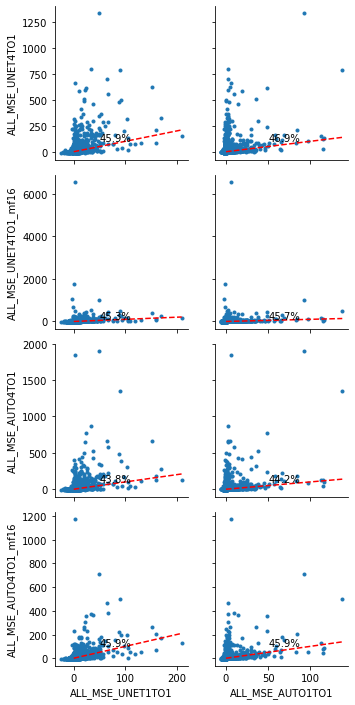

In [51]:
def cust_plot(x=None, y=None, **kwargs):
    plt.plot(x, y, '.')
    plt.text(50, 100, f"{((y>=x) & (x>-1000)).sum()/(x>-1000).sum():.1%}")
    m = min(max(x), max(y))
    plt.plot([0,m], [0,m], 'r--') 
    
    
g = sns.PairGrid(f_trt.filter(regex='ALL_MSE', axis=1), diag_sharey=False, 
                x_vars=[c for c in cols if '1TO1' in c], y_vars=[c for c in cols if '4TO1' in c])
axes = g.map(cust_plot).axes

# for axs in g.axes:
#     for ax in axs:
#         ax.set_yscale('log')
#         ax.set_xscale('log')

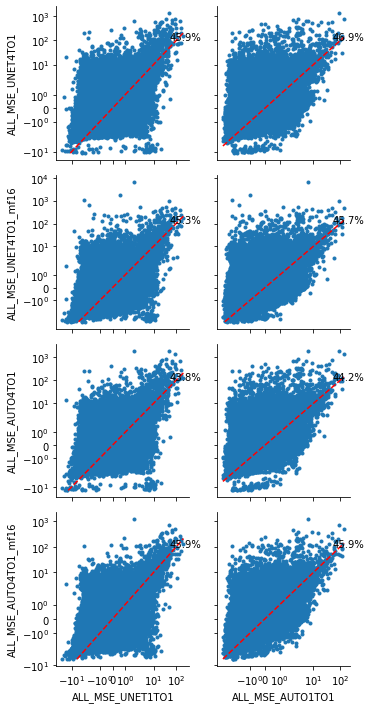

In [56]:
def cust_plot(x=None, y=None, **kwargs):
    plt.plot(x, y, '.')
    plt.text(50, 100, f"{((y>=x) & (x>-1000)).sum()/(x>-1000).sum():.1%}")
    ma = min(max(x), max(y))
    mi = max(min(x), min(y))
    plt.plot([mi,ma], [mi,ma], 'r--') 
    
    
g = sns.PairGrid(f_trt.filter(regex='ALL_MSE', axis=1), diag_sharey=False, 
                x_vars=[c for c in cols if '1TO1' in c], y_vars=[c for c in cols if '4TO1' in c])
axes = g.map(cust_plot).axes

for axs in g.axes:
    for ax in axs:
#         ax.set_xlim(0,100)
#         ax.set_ylim(0,100)
        
        ax.set_yscale('symlog')
        ax.set_xscale('symlog')

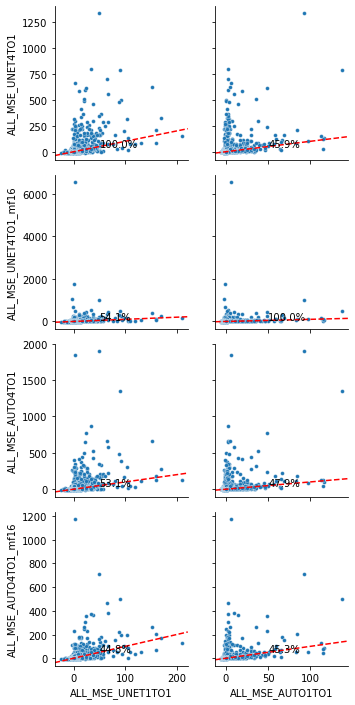

In [19]:
g = sns.PairGrid(f_trt.filter(regex='ALL_MSE', axis=1), diag_sharey=False, 
                x_vars=[c for c in cols if '1TO1' in c], y_vars=[c for c in cols if '4TO1' in c])
axes = g.map(sns.scatterplot, s=15).axes
# axes = g.map_upper(sns.scatterplot, s=15).axes
# g.map_lower(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
# x2 = g.map_diag(sns.kdeplot, lw=2)
# for axs in g.axes:
#     for ax in axs:
#         ax.set_yscale('log')
#         ax.set_xscale('log')
# for i in range(len(axes)):
#     for j in range(len(axes[0])):
#         add_identity(axes[i][j], color='r', ls='--')
#         axes[i][j].text(50,50,f"{(f_trt[cols[i]]>=f_trt[cols[j]]).sum()/f_trt.shape[0]:.1%}")

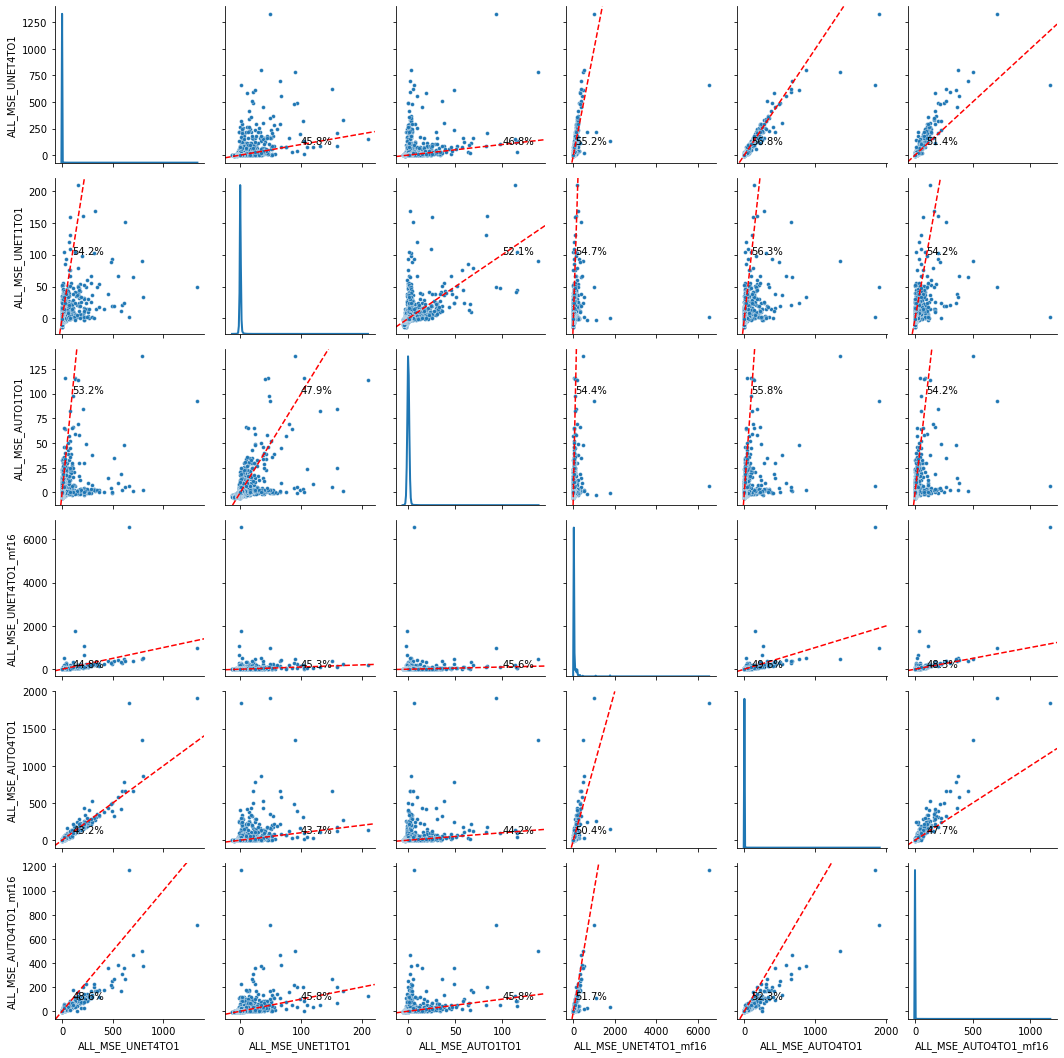

In [71]:
g = sns.PairGrid(f_trt.filter(regex='ALL_MSE', axis=1), diag_sharey=False)
axes = g.map_upper(sns.scatterplot, s=15).axes
_ = g.map_lower(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
_ = g.map_diag(sns.kdeplot, lw=2)

# for axs in g.axes:
#     for ax in axs:
#         ax.set_yscale('symlog')
#         ax.set_xscale('symlog')


for i in range(6):
    for j in range(6):
        if i != j:
            add_identity(axes[i][j], color='r', ls='--')
            axes[i][j].text(100,100,f"{(f_trt[cols[i]]>f_trt[cols[j]]).sum()/f_trt.shape[0]:.1%}")

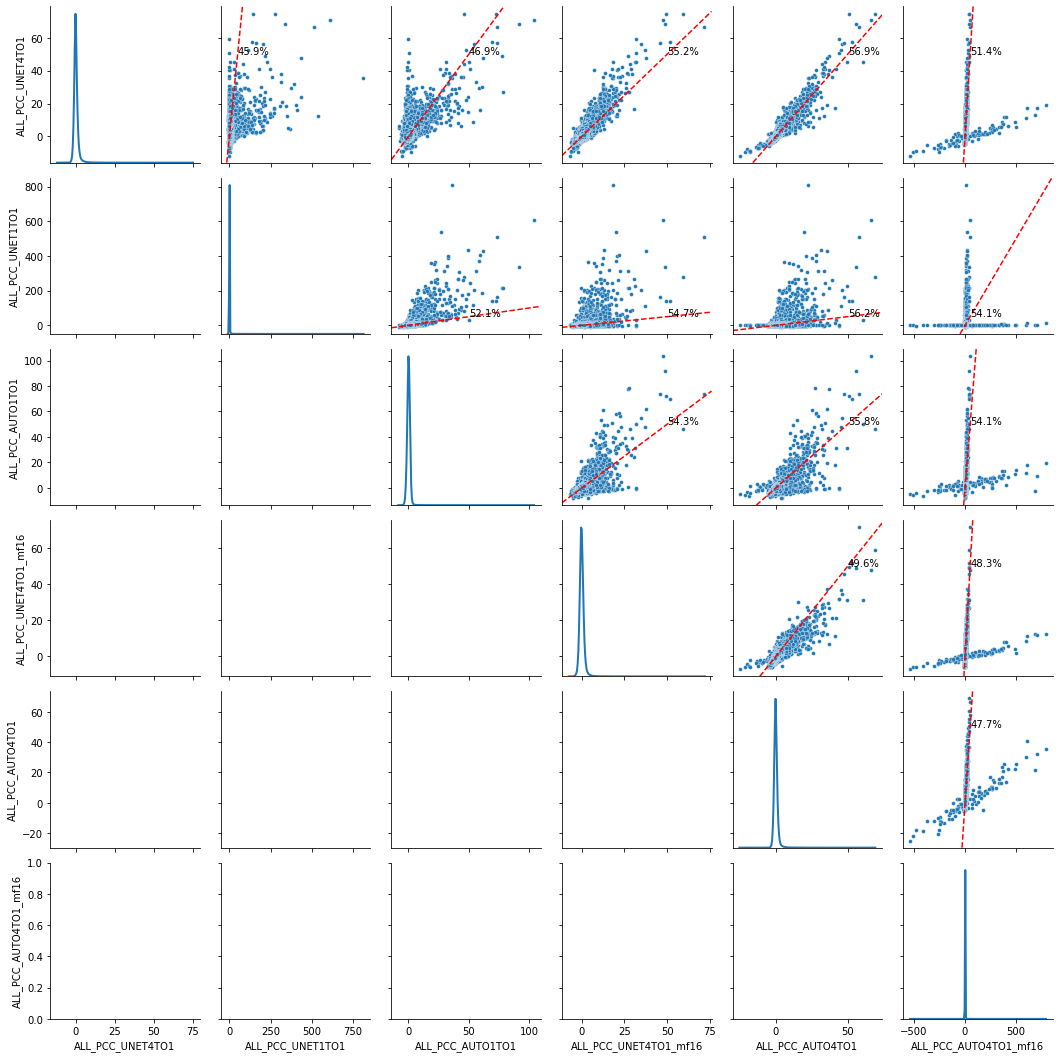

In [13]:
g = sns.PairGrid(f_trt.filter(regex='ALL_PCC', axis=1)*-1, diag_sharey=False)
axes = g.map_upper(sns.scatterplot, s=15).axes
# g.map_lower(sns.kdeplot)
_ = g.map_diag(sns.kdeplot, lw=2)
# for axs in g.axes:
#     for ax in axs:
#         ax.set_yscale('log')
#         ax.set_xscale('log')


for i in range(6):
    for j in range(i+1,6):
        add_identity(axes[i][j], color='r', ls='--')
        axes[i][j].text(50,50,f"{(f_trt[cols[i]]>f_trt[cols[j]]).sum()/f_trt.shape[0]:.1%}")

In [7]:
res={model: pd.concat([pd.read_csv(pth, index_col=[0,1,2,3]) for pth in glob(f'./30000/results/z_scores/{m}/*.csv')]) for model, m in zip(['AUTO1T01', 'UNET4TO1'], ['raw1to1','err'])}

final_res = res['UNET4TO1'].join(res['AUTO1T01'], lsuffix='_4to1', rsuffix='_1to1')
final_res

In [29]:
final_trts = final_res.query('Well_Role != "mock"')
final_trts.index = final_trts.index.droplevel([1,3])
final_trts

RNA_PCC_4to1  RNA_MSE_4to1  Mito_PCC_4to1  \
Plate Broad_Sample                                                        
24300 BRD-A00100033-001-04-8      0.950165      0.413856      -5.103771   
      BRD-A00267231-001-01-1      2.291434     -0.314747       0.333678   
      BRD-A00327403-103-01-9     -0.381040     -0.953115      -5.520413   
      BRD-A00520476-001-03-3      1.779440     -0.158736       0.301246   
      BRD-A00827783-001-04-8      1.111024     -1.143765       0.699830   
...                                    ...           ...            ...   
26744 BRD-K99100793-001-01-4      0.920502     -1.019336       0.750357   
      BRD-K99155518-001-01-2      2.443008     -1.403596       2.251598   
      BRD-K99161484-001-01-0      0.719791     -0.747954       1.112754   
      BRD-K99737029-001-01-9      2.970795     -1.224742       1.282350   
      BRD-K99763083-001-01-8      2.708685     -1.605443       1.988253   

                              Mito_MSE_4to1  ER_PCC_4to1  ER_MSE_4to1  \
Plate Broad_Sample                                                      
24300 BRD-A00100033-001-04-8       1.164043     0.473808    -1.364747   
      BRD-A00267231-001-01-1      -0.285391     1.454114    -1.008902   
      BRD-A00327403-103-01-9       0.431104     0.265541    -1.532614   
      BRD-A00520476-001-03-3      -0.541038     0.353746    -0.362138   
      BRD-A00827783-001-04-8      -0.678627     0.873234    -1.208432   
...                                     ...          ...          ...   
26744 BRD-K99100793-001-01-4      -1.368530     0.869557    -1.628083   
      BRD-K99155518-001-01-2       0.099134     0.591695    -1.208699   
      BRD-K99161484-001-01-0      -0.300082     1.089726    -0.697231   
      BRD-K99737029-001-01-9       0.971854     0.065990    -1.377260   
      BRD-K99763083-001-01-8       0.027558     1.476297    -1.708374   

                              DNA_PCC_4to1  DNA_MSE_4to1  AGP_PCC_4to1  \
Plate Broad_Sample                                                       
24300 BRD-A00100033-001-04-8      0.217200     -0.633919      1.540316   
      BRD-A00267231-001-01-1      0.372256     -0.800150      1.975467   
      BRD-A00327403-103-01-9      0.590165     -1.002020      1.058145   
      BRD-A00520476-001-03-3      0.191561     -0.430501      1.850624   
      BRD-A00827783-001-04-8      0.412160     -0.750089      1.681812   
...                                    ...           ...           ...   
26744 BRD-K99100793-001-01-4     -0.110559      2.230848      1.249323   
      BRD-K99155518-001-01-2      1.394172     -1.088388      1.741169   
      BRD-K99161484-001-01-0      0.837395      0.082258      0.882690   
      BRD-K99737029-001-01-9      1.212726     -1.106534      3.109515   
      BRD-K99763083-001-01-8      1.501674     -0.549494      3.595078   

                              AGP_MSE_4to1  ...  DNA_PCC_1to1  DNA_MSE_1to1  \
Plate Broad_Sample                          ...                               
24300 BRD-A00100033-001-04-8     -1.109493  ...      0.681763     -1.478510   
      BRD-A00267231-001-01-1     -1.603114  ...      2.186570     -2.041777   
      BRD-A00327403-103-01-9     -0.738433  ...      0.274960     -1.398128   
      BRD-A00520476-001-03-3     -1.310850  ...      1.737854     -1.416090   
      BRD-A00827783-001-04-8     -1.285742  ...      1.436725     -1.356891   
...                                    ...  ...           ...           ...   
26744 BRD-K99100793-001-01-4     -1.667839  ...      1.773783     -0.644880   
      BRD-K99155518-001-01-2     -1.878496  ...      1.838445     -2.057585   
      BRD-K99161484-001-01-0     -0.712763  ...      1.452769     -0.579634   
      BRD-K99737029-001-01-9     -2.164543  ...      1.182143     -2.023039   
      BRD-K99763083-001-01-8     -2.514531  ...      2.000097     -1.729152   

                              ER_PCC_1to1  ER_MSE_1to1  Mito_PCC_1to1  \
Plate Broad_Sample                      

In [30]:
trts = final_trts

In [26]:
trts = final_trts.query(f'ALL_PCC_4to1 <=-9 or ALL_PCC_1to1 <=-9')

In [37]:
trts = final_trts.query(f'ALL_MSE_4to1 >=5 or ALL_MSE_1to1 >=5')

In [15]:
combins = [('MSE', '4to1', 'MSE', '1to1'),
           ('PCC', '4to1', 'PCC', '1to1'),
#            ('PCC', '4to1', 'MSE', '4to1'),
#            ('PCC', '1to1', 'MSE', '1to1'),
          ]

In [27]:
f'{kind_y}-{metric_y}({kind_x}-{metric_x}).eps'

'4to1-PCC(4to1-MSE).eps'

## New Plots

In [13]:
plates = f_trt.index.get_level_values(0).unique().to_numpy()
plates.sort()
len(plates)

395

In [14]:
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, len(plates))]
# colors = np.random.permutation(colors)

In [19]:
y_methods = [c[8:] for c in cols if '4TO1' in c]
x_methods = [c[8:] for c in cols if '1TO1' in c]
for y_mtd in y_methods:
    for x_mtd in x_methods:
        print(f'{y_mtd}({x_mtd})')

UNET4TO1(UNET1TO1)
UNET4TO1(AUTO1TO1)
UNET4TO1_mf16(UNET1TO1)
UNET4TO1_mf16(AUTO1TO1)
AUTO4TO1(UNET1TO1)
AUTO4TO1(AUTO1TO1)
AUTO4TO1_mf16(UNET1TO1)
AUTO4TO1_mf16(AUTO1TO1)


In [10]:
combs = [
    ('UNET1TO1', 'UNET4TO1_mf16'),
    ('AUTO1TO1', 'AUTO4TO1_mf16'),
    ('AUTO4TO1_mf16', 'UNET4TO1_mf16'),
    ('AUTO1TO1', 'UNET1TO1'),
]

In [11]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

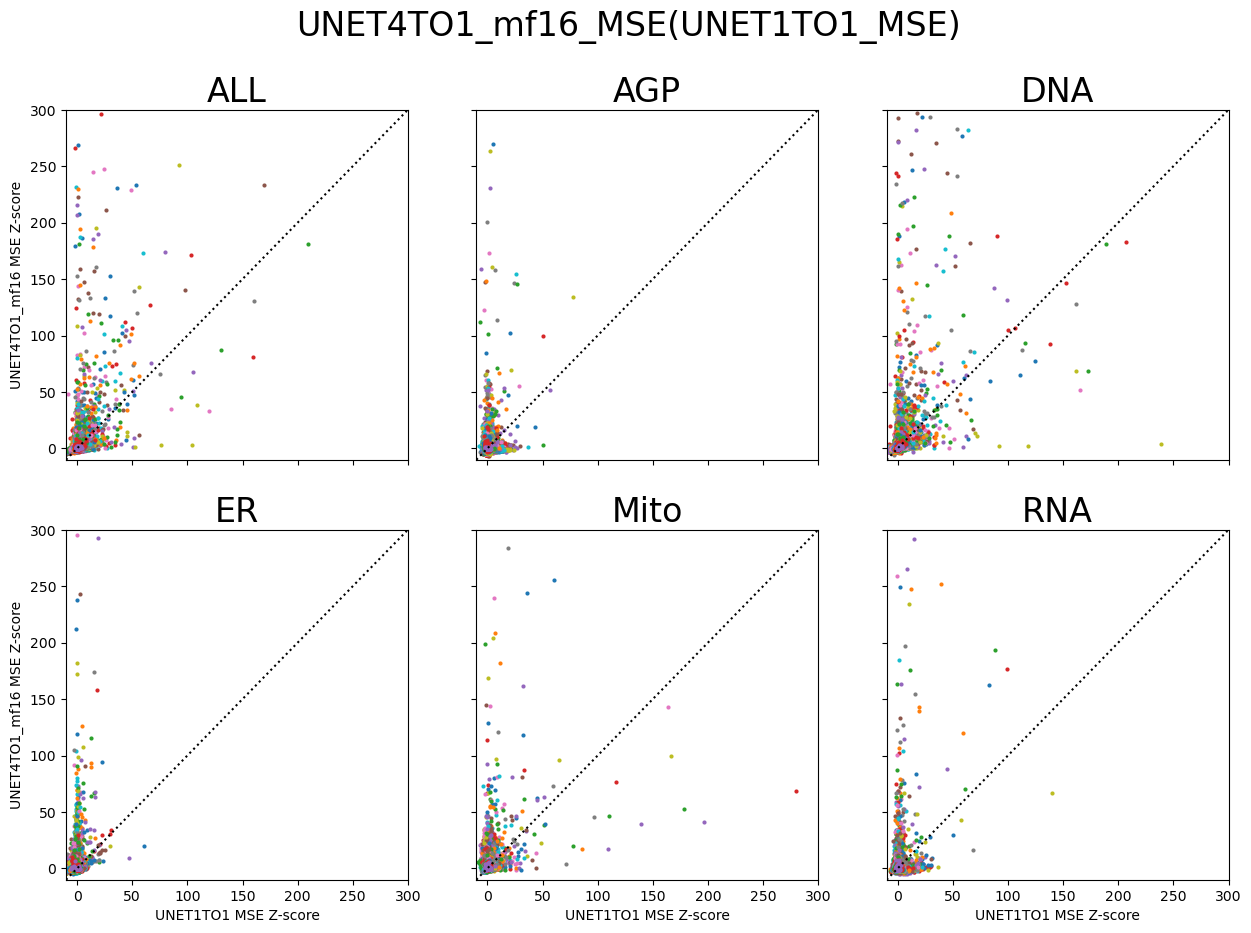

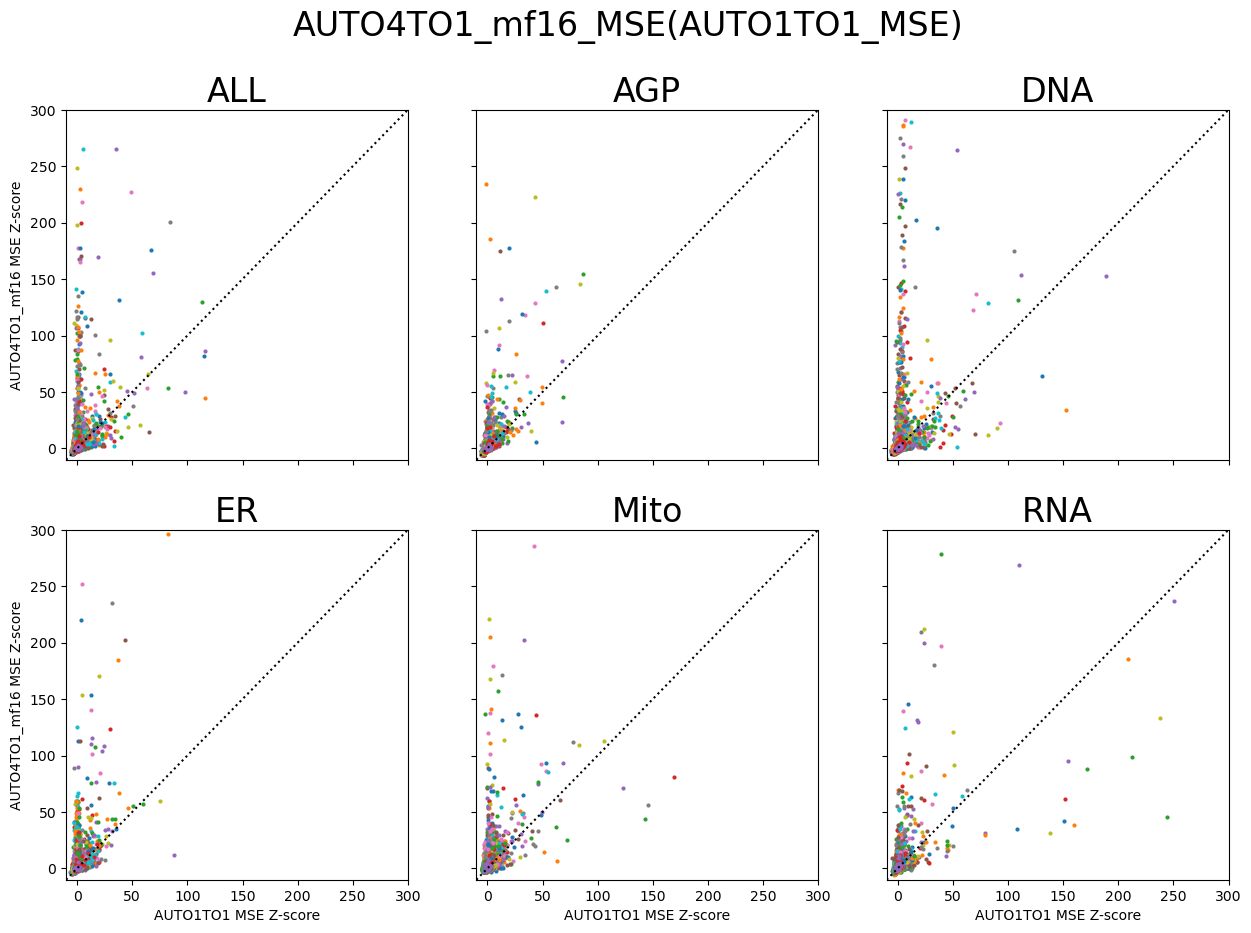

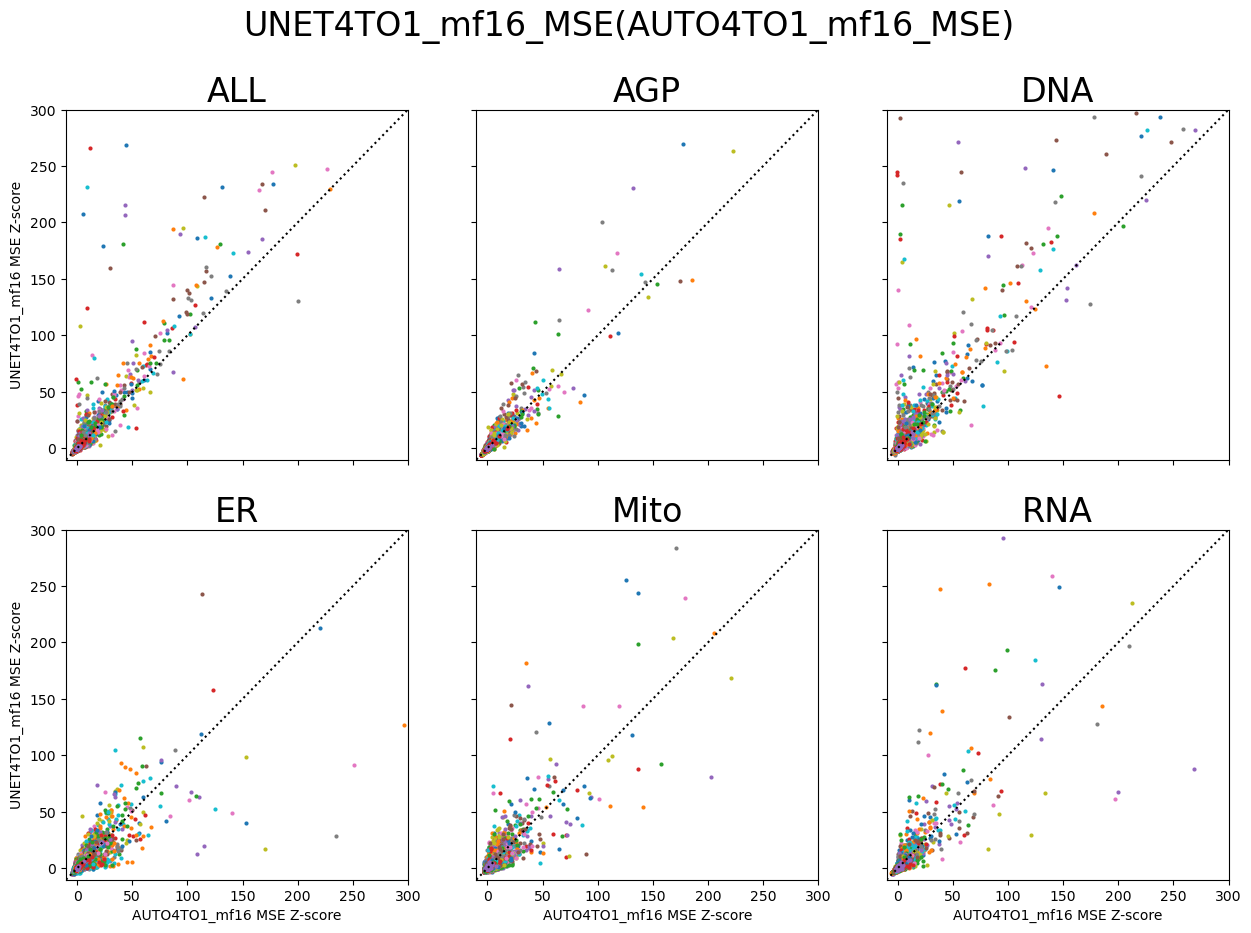

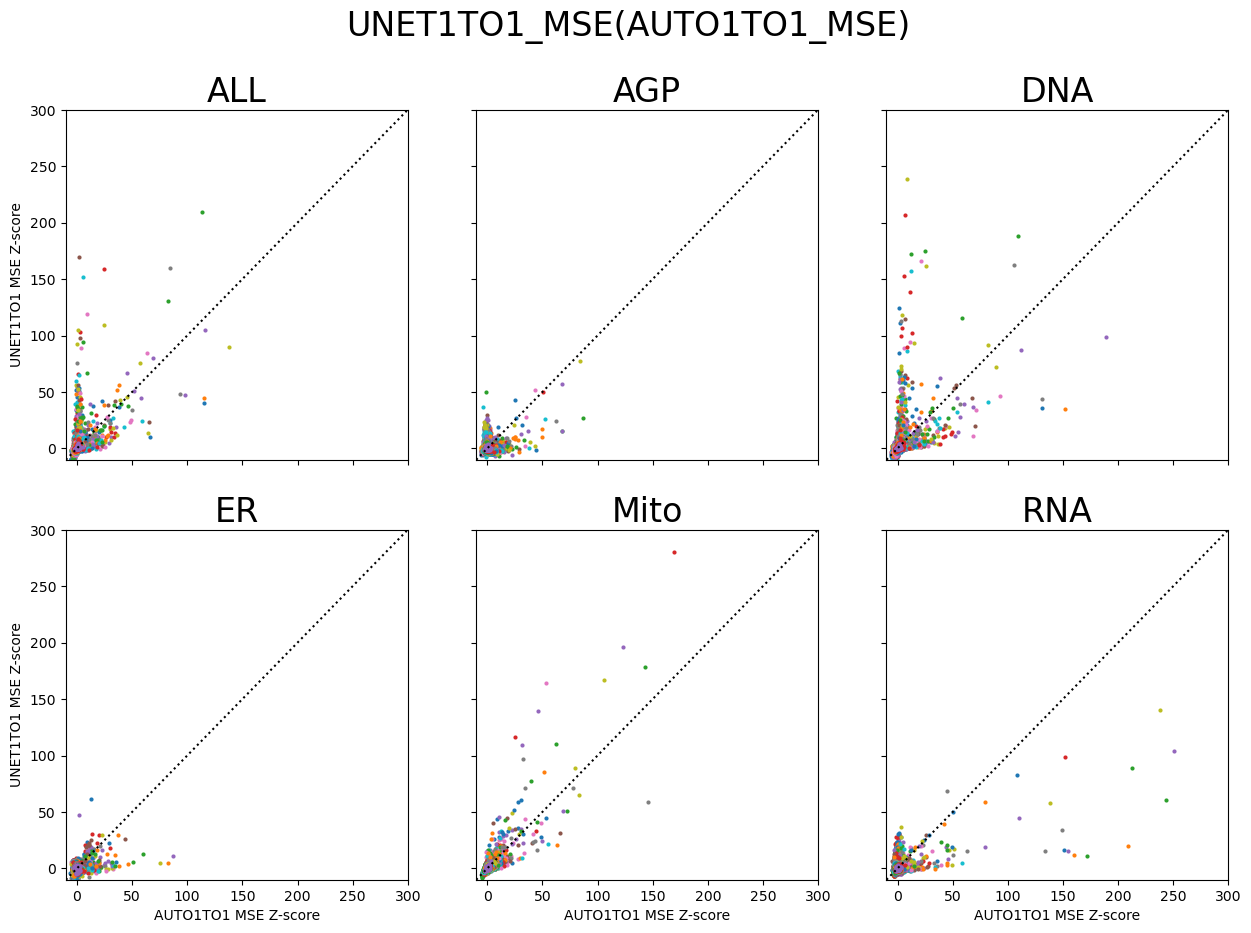

In [16]:
nrows = 2
ncols = 3

for metric in ['MSE']:#, 'PCC']:
    for x_mtd, y_mtd in combs:
        d={'xlabel':f"{x_mtd} {metric} Z-score", 'ylabel':f"{y_mtd} {metric} Z-score"}
        fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*5,nrows*5), sharex=True, sharey=True, subplot_kw=d)
        fig.suptitle(f'{y_mtd}_{metric}({x_mtd}_{metric})', fontsize = 24)

        mul_metric = -1 if metric == 'PCC' else 1

        for i, chan in enumerate(['ALL', 'AGP', 'DNA', 'ER', 'Mito', 'RNA']):
            for p, color in zip(plates, colors):
                ax[i//ncols, i%ncols].plot(f_trt.loc[p][f'{chan}_{metric}_{x_mtd}']*mul_metric, f_trt.loc[p][f'{chan}_{metric}_{y_mtd}']*mul_metric, '.', markeredgewidth=0)
    #         sns.kdeplot(x=trts[f'{chan}_{metric_x}_{kind_x}']*mul_x, y=trts[f'{chan}_{metric_y}_{kind_y}']*mul_y,ax=ax[i//ncols, i%ncols], clip=(-10,100))
            ax[i//ncols, i%ncols].set_title(chan, fontsize=24)
            ax[i//ncols, i%ncols].plot(range(-10,300), range(-10,300), 'k:')
            ax[i//ncols, i%ncols].set_xlim(-10, 300)
            ax[i//ncols, i%ncols].set_ylim(-10, 300)
    #         ax[i//ncols, i%ncols].set_xscale('symlog')
    #         ax[i//ncols, i%ncols].set_yscale('symlog')
            if not i//ncols:
                ax[i//ncols, i%ncols].set_xlabel('')
            if i%ncols:
                ax[i//ncols, i%ncols].set_ylabel('')

        # fig.savefig(f'./30000/plots/{y_mtd}_{metric}({x_mtd}_{metric}).png', format='png')
        # fig.savefig(f'./30000/plots/{y_mtd}_{metric}({x_mtd}_{metric}).eps', format='eps')
        # fig.savefig(f'./30000/plots/{y_mtd}_{metric}({x_mtd}_{metric}).pdf', format='pdf', transparent=True)
        plt.show()

In [28]:
f_trt.describe().T.filter(like='ALL_MSE', axis=0)

,count,mean,std,min,25%,50%,75%,max
ALL_MSE_UNET4TO1,125947.0,0.348991,9.598980,-4.202602,-0.558215,-0.216842,0.166715,1333.525093
ALL_MSE_UNET1TO1,125947.0,0.023296,2.353398,-13.134304,-0.654993,-0.122004,0.511418,209.721339
ALL_MSE_AUTO1TO1,125947.0,-0.078398,1.725438,-5.727904,-0.810079,-0.140565,0.544723,138.141243
ALL_MSE_UNET4TO1_mf16,125947.0,0.289068,20.630710,-4.771326,-0.593320,-0.233713,0.174162,6554.796732
ALL_MSE_AUTO4TO1,125947.0,0.314179,11.947531,-4.737766,-0.610323,-0.233086,0.142718,1905.077293
ALL_MSE_AUTO4TO1_mf16,125947.0,0.142285,6.155948,-4.730818,-0.604573,-0.218914,0.234149,1172.660495


In [ ]:
final_trts.drop_index

In [ ]:
metric = 'PCC'

In [33]:
n=2
from random import sample
sample(list(trts.index), n*n)

[(24294, 'BRD-A03359064-001-01-5'),
 (24294, 'BRD-A07195938-001-01-3'),
 (24640, 'BRD-K13781734-001-02-4'),
 (24294, 'BRD-A33447119-001-02-5')]

In [53]:
'BRD-K52313696-001-01-6'
trts[trts.index.isin(['BRD-K52313696-001-01-6'], 1)].index

MultiIndex([(24311, 'BRD-K52313696-001-01-6'),
            (25985, 'BRD-K52313696-001-01-6'),
            (25987, 'BRD-K52313696-001-01-6')],
           names=['Plate', 'Broad_Sample'])

In [36]:
trts = final_trts.query(f'ALL_MSE_4to1 >=10 or ALL_MSE_1to1 <=10')
trts

AGP_PCC_4to1  AGP_MSE_4to1  DNA_PCC_4to1  \
Plate Broad_Sample                                                       
24792 BRD-K25512917-001-01-0      1.124655      0.495083     -0.620889   
      BRD-K15444424-001-01-4      2.260974     -0.333697      0.199720   
      BRD-K35088248-001-01-9      1.544360     -0.338333      1.825432   
      BRD-K15792876-001-01-9      2.803465     -0.716515      1.257638   
      BRD-K11487484-001-01-4      2.973976     -0.743210     -0.783805   
...                                    ...           ...           ...   
24661 BRD-K89697867-001-01-2      1.486042      1.102040     -0.212639   
      BRD-K72872827-001-01-9     -3.195318    140.548321     -6.249173   
      BRD-K79106177-001-01-1      0.050999      2.537754    -15.418912   
      BRD-K69880993-001-01-5      0.344582      4.645240     -1.586832   
      BRD-K22246751-001-01-7      0.870301      1.568818     -0.222289   

                              DNA_MSE_4to1  ER_PCC_4to1  ER_MSE_4to1  \
Plate Broad_Sample                                                     
24792 BRD-K25512917-001-01-0      1.374876     0.773558    -0.149477   
      BRD-K15444424-001-01-4      0.370263     0.757169    -0.260365   
      BRD-K35088248-001-01-9     -0.193957     1.014697    -0.192510   
      BRD-K15792876-001-01-9     -0.621994     0.884223    -0.201394   
      BRD-K11487484-001-01-4     -0.705443     0.060129    -0.101173   
...                                    ...          ...          ...   
24661 BRD-K89697867-001-01-2     -0.149486     0.452701    -0.853636   
      BRD-K72872827-001-01-9      3.767127   -10.367789    41.672749   
      BRD-K79106177-001-01-1      8.991241    -1.539475     8.552387   
      BRD-K69880993-001-01-5      0.000738   -10.838316    14.835099   
      BRD-K22246751-001-01-7     -0.112139     0.173882    -0.980564   

                              Mito_PCC_4to1  Mito_MSE_4to1  RNA_PCC_4to1  \
Plate Broad_Sample                                                         
24792 BRD-K25512917-001-01-0      -0.453550       2.813984     -0.566209   
      BRD-K15444424-001-01-4       0.677377       0.853984      1.733558   
      BRD-K35088248-001-01-9       0.397206       0.165966      0.761404   
      BRD-K15792876-001-01-9       0.831974      -0.586837      2.173650   
      BRD-K11487484-001-01-4      -0.256511      -0.804778      2.506914   
...                                     ...            ...           ...   
24661 BRD-K89697867-001-01-2       1.688836      -0.450945      1.416662   
      BRD-K72872827-001-01-9      -3.080414      69.342862     -0.555696   
      BRD-K79106177-001-01-1      -3.497533       1.822632     -3.185687   
      BRD-K69880993-001-01-5      -1.013403      -0.092981      0.277528   
      BRD-K22246751-001-01-7       0.384867      -0.987940      0.210619   

                              RNA_MSE_4to1  ...  DNA_PCC_1to1  DNA_MSE_1to1  \
Plate Broad_Sample                          ...                               
24792 BRD-K25512917-001-01-0      1.440060  ...     -0.885797     -0.903881   
      BRD-K15444424-001-01-4     -0.085241  ...     -0.925360     -0.835524   
      BRD-K35088248-001-01-9     -0.102222  ...      0.416739     -0.939241   
      BRD-K15792876-001-01-9     -0.749602  ...      0.462707     -2.036241   
      BRD-K11487484-001-01-4     -0.784035  ...     -3.021189     -1.476898   
...                                    ...  ...           ...           ...   
24661 BRD-K89697867-001-01-2      1.482691  ...      1.079050     -1.437115   
      BRD-K72872827-001-01-9    214.368469  ...     -8.494681     24.195046   
      BRD-K79106177-001-01-1      8.667292  ...      0.697963      9.010067   
      BRD-K69880993-001-01-5      6.447281  ...     -0.078830      1.208960   
      BRD-K22246751-001-01-7      0.385827  ...      0.581944     -0.761878   

                              ER_PCC_1to1  ER_MSE_1to1  Mito_PCC_1to1  \
Plate Broad_Sample                      

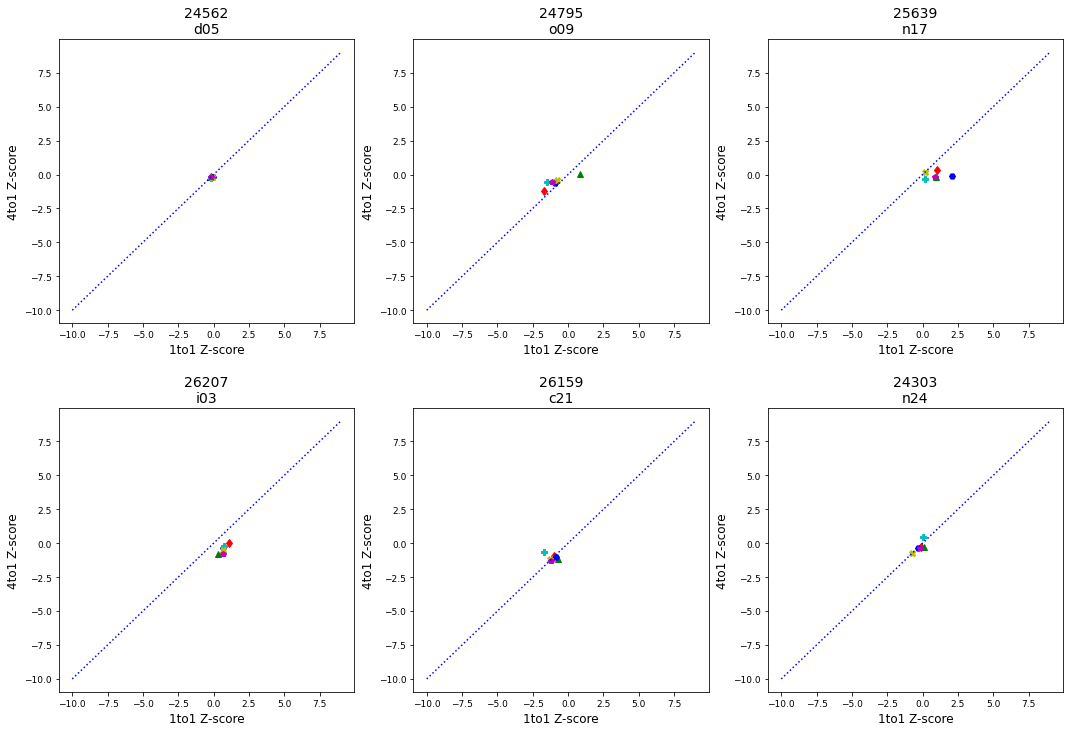

In [ ]:
from random import sample

markers = ['d', '^', 'H', 'P', 'X','p']
colors = ['r', 'g', 'b', 'c', 'y', 'm']
nrows = 2
ncols = 3
metric = 'MSE'
mul_m = 1

samples = sample(list(trts.index), nrows*ncols)
# samples = [(25571, 'BRD-K66760553-001-06-3'),
#     (24509, 'BRD-K15876355-001-01-0'),
#     (25945, 'BRD-A52660433-066-01-3'),
#     (25575, 'BRD-K14096728-001-05-7'),
#     (26622, 'BRD-K07982814-001-01-1'),
#     (24321, 'BRD-K67439147-001-01-7')]
# samples = [(24311, 'BRD-K52313696-001-01-6'),
#             (25985, 'BRD-K52313696-001-01-6'),
#             (25987, 'BRD-K52313696-001-01-6')]
d={'xlabel':"1to1 Z-score", 'ylabel':"4to1 Z-score"}

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6), sharey=True, sharex=True, subplot_kw=d, facecolor='white')
fig.subplots_adjust(hspace=0.3, wspace=0.2)
# fig.suptitle(f'Comapring Z-score - raw features vs. mappings', fontsize = 24)

symbols = [0,0,0,0,0,0]
for i, sample in enumerate(samples):
    z_scores = trts[trts.index.isin([sample])]


#     cols = zip(z_features.columns, z_mapping.columns)
    for j, chan in enumerate(['AGP', 'DNA', 'ER', 'Mito', 'RNA']):
        symbols[j] = ax[i%nrows, i//nrows].plot(z_scores[f'{chan}_{metric}_1to1']*mul_m, z_scores[f'{chan}_{metric}_4to1']*mul_m, f'{colors[j]}{markers[j]}')[0]
        
    symbols[-1] = ax[i%nrows, i//nrows].plot(z_scores[f'ALL_{metric}_1to1']*mul_m, z_scores[f'ALL_{metric}_4to1']*mul_m, f'{colors[-1]}{markers[-1]}')[0]

    ax[i%nrows, i//nrows].plot(range(-10, 10),range(-10, 10), 'b:')
#     ax[i%nrows, i//nrows].set(xlim=(-10, 130), ylim=(-10, 130))
#     ax[i%nrows, i//nrows].set_yscale('symlog')
#     ax[i%nrows, i//nrows].set_xscale('symlog')
    ax[i%nrows, i//nrows].set_title(f'{sample[0]}\n{sample[1]}', )
    ax[i%nrows, i//nrows].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                     bottom=True, top=False, left=True, right=False)
    ax[i%nrows, i//nrows].tick_params(axis='both', labelsize = 9)
    ax[i%nrows, i//nrows].yaxis.label.set_size(12)
    ax[i%nrows, i//nrows].xaxis.label.set_size(12)
    ax[i%nrows, i//nrows].title.set_size(14)
    
# handles, labels = ax[0,0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# fig.legend(symbols, ['AGP', 'DNA', 'ER', 'Mito', 'RNA', 'ALL'], markerscale=1.2, fontsize='x-large')
# fig.savefig(f'{plots_path}/final_compounds.png')

plt.show()

In [8]:
final_res.reset_index().columns

Index(['Plate', 'Well_Role', 'Broad_Sample', 'Well', 'RNA_PCC_4to1',
       'RNA_MSE_4to1', 'Mito_PCC_4to1', 'Mito_MSE_4to1', 'ER_PCC_4to1',
       'ER_MSE_4to1', 'DNA_PCC_4to1', 'DNA_MSE_4to1', 'AGP_PCC_4to1',
       'AGP_MSE_4to1', 'ALL_PCC_4to1', 'ALL_MSE_4to1', 'AGP_PCC_1to1',
       'AGP_MSE_1to1', 'DNA_PCC_1to1', 'DNA_MSE_1to1', 'ER_PCC_1to1',
       'ER_MSE_1to1', 'Mito_PCC_1to1', 'Mito_MSE_1to1', 'RNA_PCC_1to1',
       'RNA_MSE_1to1', 'ALL_PCC_1to1', 'ALL_MSE_1to1'],
      dtype='object')

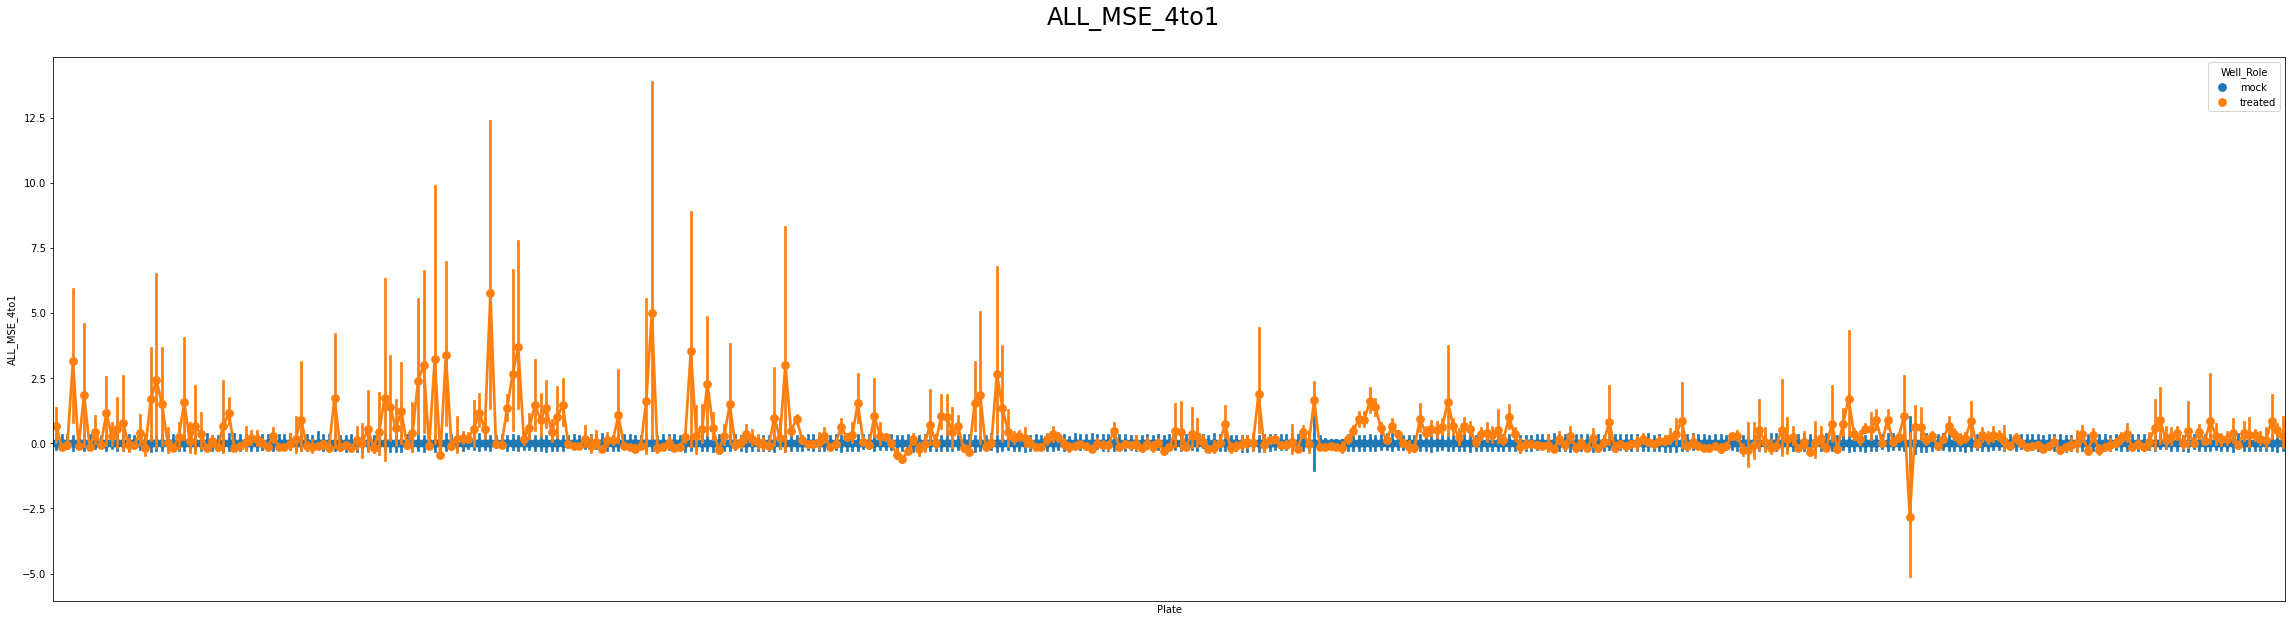

In [19]:
fig, ax = plt.subplots(figsize=(40,10), facecolor='white')
fig.suptitle(f'ALL_MSE_4to1', fontsize = 24, y = 0.95)
sns.pointplot(data=final_res.reset_index(), x='Plate', y='ALL_MSE_4to1', hue='Well_Role', ax=ax)
ax.tick_params(axis='x', labelrotation=90, bottom=False, labelbottom=False)

# ax.set_ylim(-0.3, 0.3)

(-2.0, 2.0)

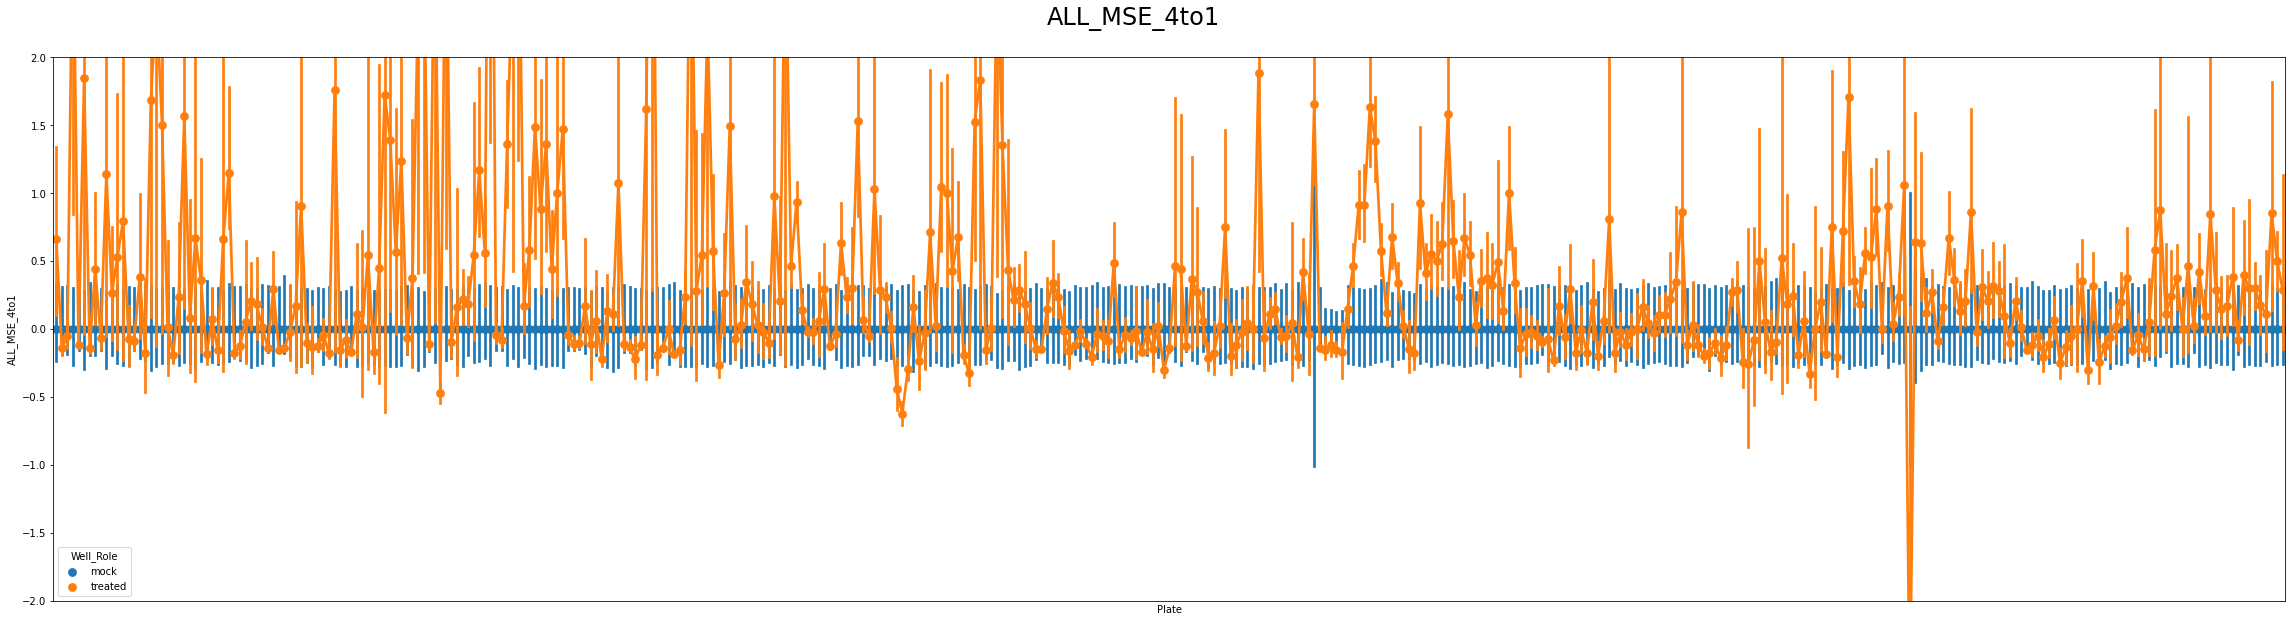

In [20]:
fig, ax = plt.subplots(figsize=(40,10), facecolor='white')
fig.suptitle(f'ALL_MSE_4to1', fontsize = 24, y = 0.95)
sns.pointplot(data=final_res.reset_index(), x='Plate', y='ALL_MSE_4to1', hue='Well_Role', ax=ax)
ax.tick_params(axis='x', labelrotation=90, bottom=False, labelbottom=False)

ax.set_ylim(-2, 2)

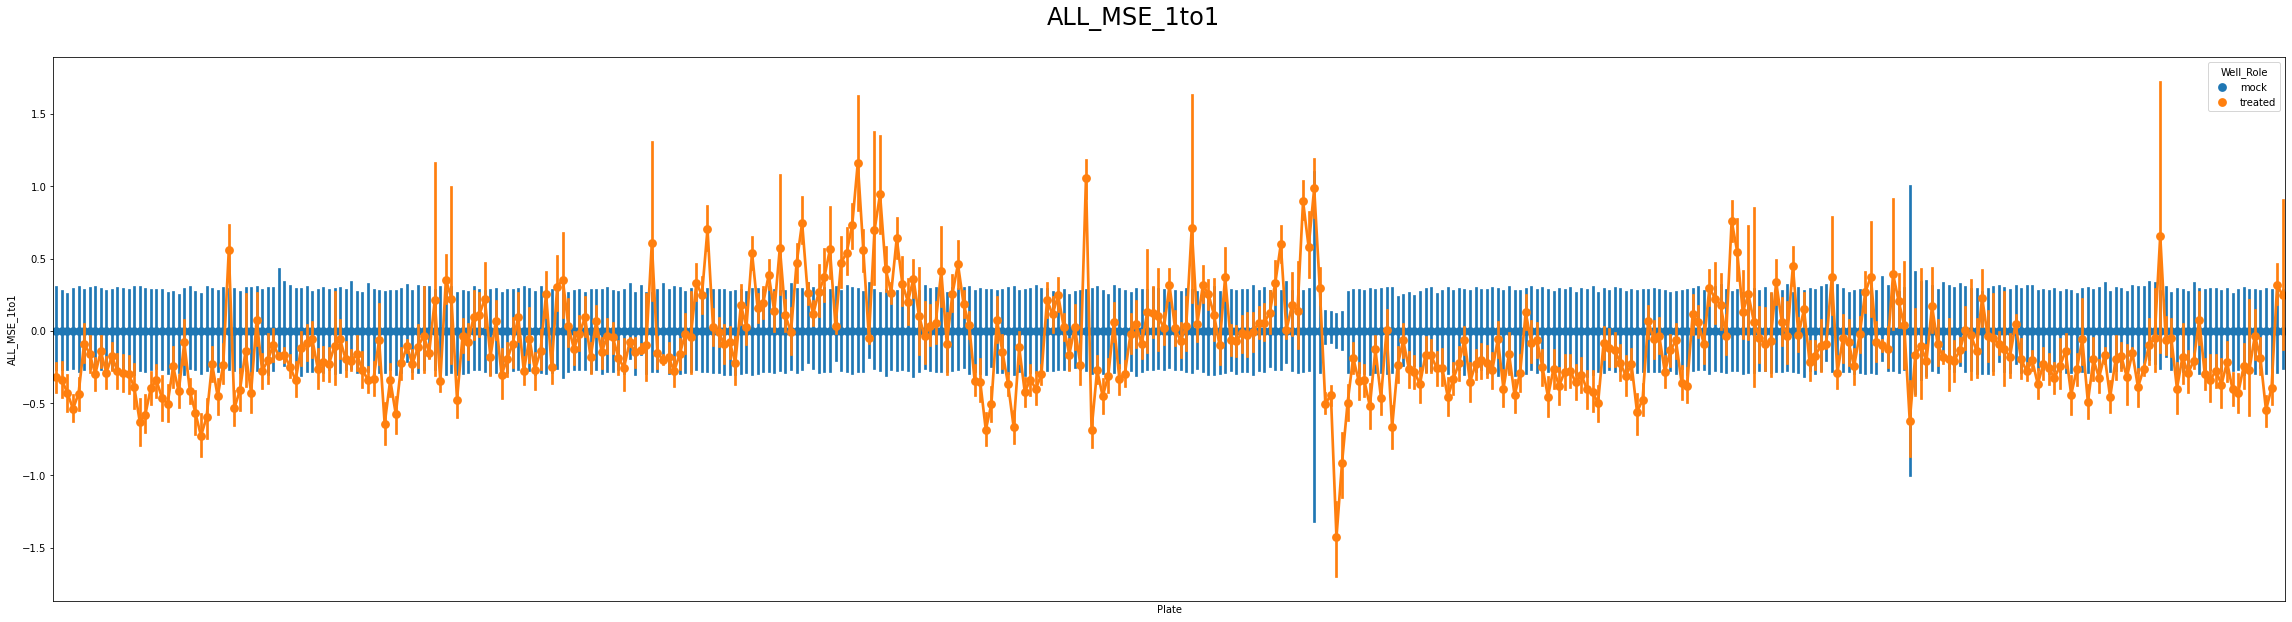

In [21]:
fig, ax = plt.subplots(figsize=(40,10), facecolor='white')
fig.suptitle(f'ALL_MSE_1to1', fontsize = 24, y = 0.95)
sns.pointplot(data=final_res.reset_index(), x='Plate', y='ALL_MSE_1to1', hue='Well_Role', ax=ax)
ax.tick_params(axis='x', labelrotation=90, bottom=False, labelbottom=False)

# ax.set_ylim(-0.3, 0.3)
#  ll = len(g.collections) plt.setp(g.collections[:ll/2], alpha=.3)
# g=sns.pointplot(x=0, y=1, data=df, dodge=True,plot_kws=dict(alpha=0.3))
# plt.setp(g.collections, alpha=.3) #for the markers
# plt.setp(g.lines, alpha=.3)

(-2.0, 2.0)

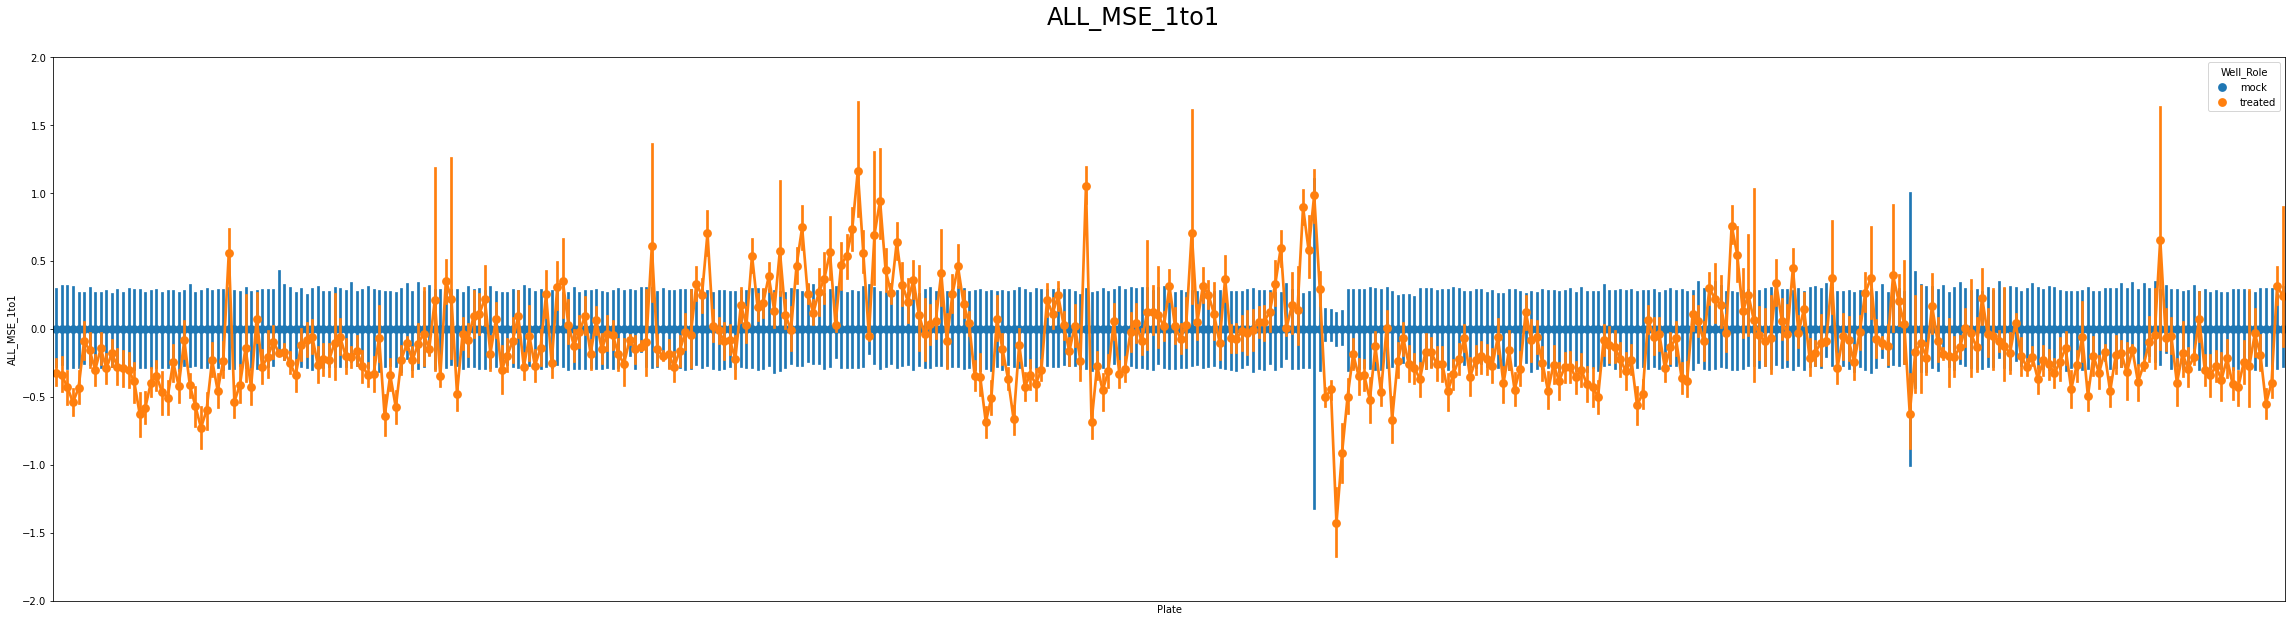

In [24]:
fig, ax = plt.subplots(figsize=(40,10), facecolor='white')
fig.suptitle(f'ALL_MSE_1to1', fontsize = 24, y = 0.95)
sns.pointplot(data=final_res.reset_index(), x='Plate', y='ALL_MSE_1to1', hue='Well_Role', ax=ax)
ax.tick_params(axis='x', labelrotation=90, bottom=False, labelbottom=False)

ax.set_ylim(-2, 2)
#  ll = len(g.collections) plt.setp(g.collections[:ll/2], alpha=.3)
# g=sns.pointplot(x=0, y=1, data=df, dodge=True,plot_kws=dict(alpha=0.3))
# plt.setp(g.collections, alpha=.3) #for the markers
# plt.setp(g.lines, alpha=.3)

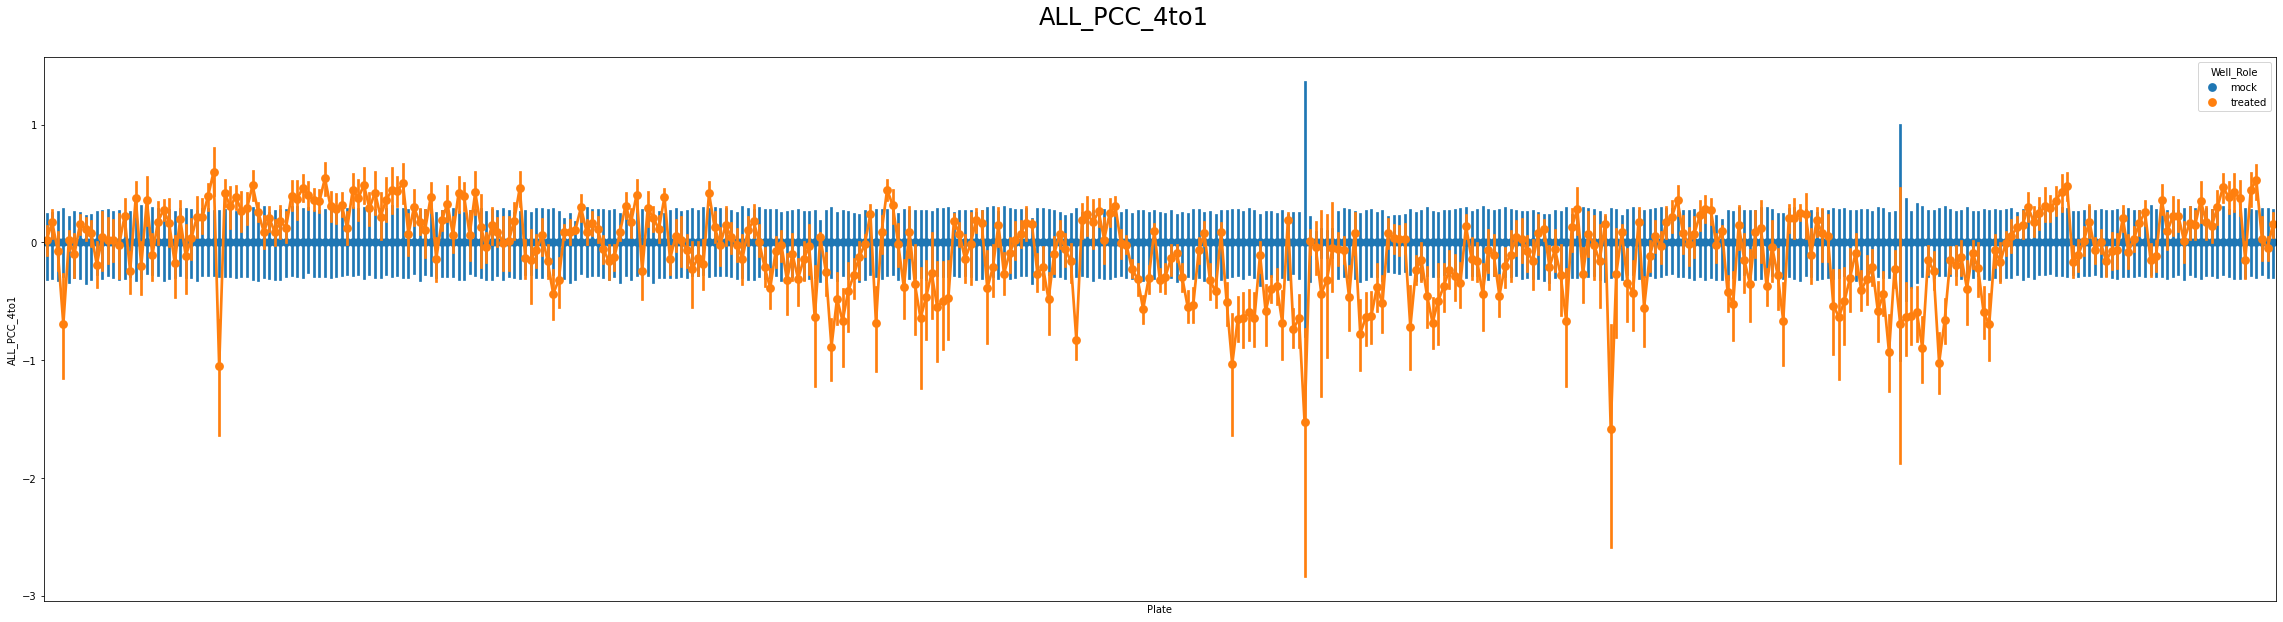

In [22]:
fig, ax = plt.subplots(figsize=(40,10), facecolor='white')
fig.suptitle(f'ALL_PCC_4to1', fontsize = 24, y = 0.95)
sns.pointplot(data=final_res.reset_index(), x='Plate', y='ALL_PCC_4to1', hue='Well_Role', ax=ax)
ax.tick_params(axis='x', labelrotation=90, bottom=False, labelbottom=False)

# ax.set_ylim(-0.3, 0.3)

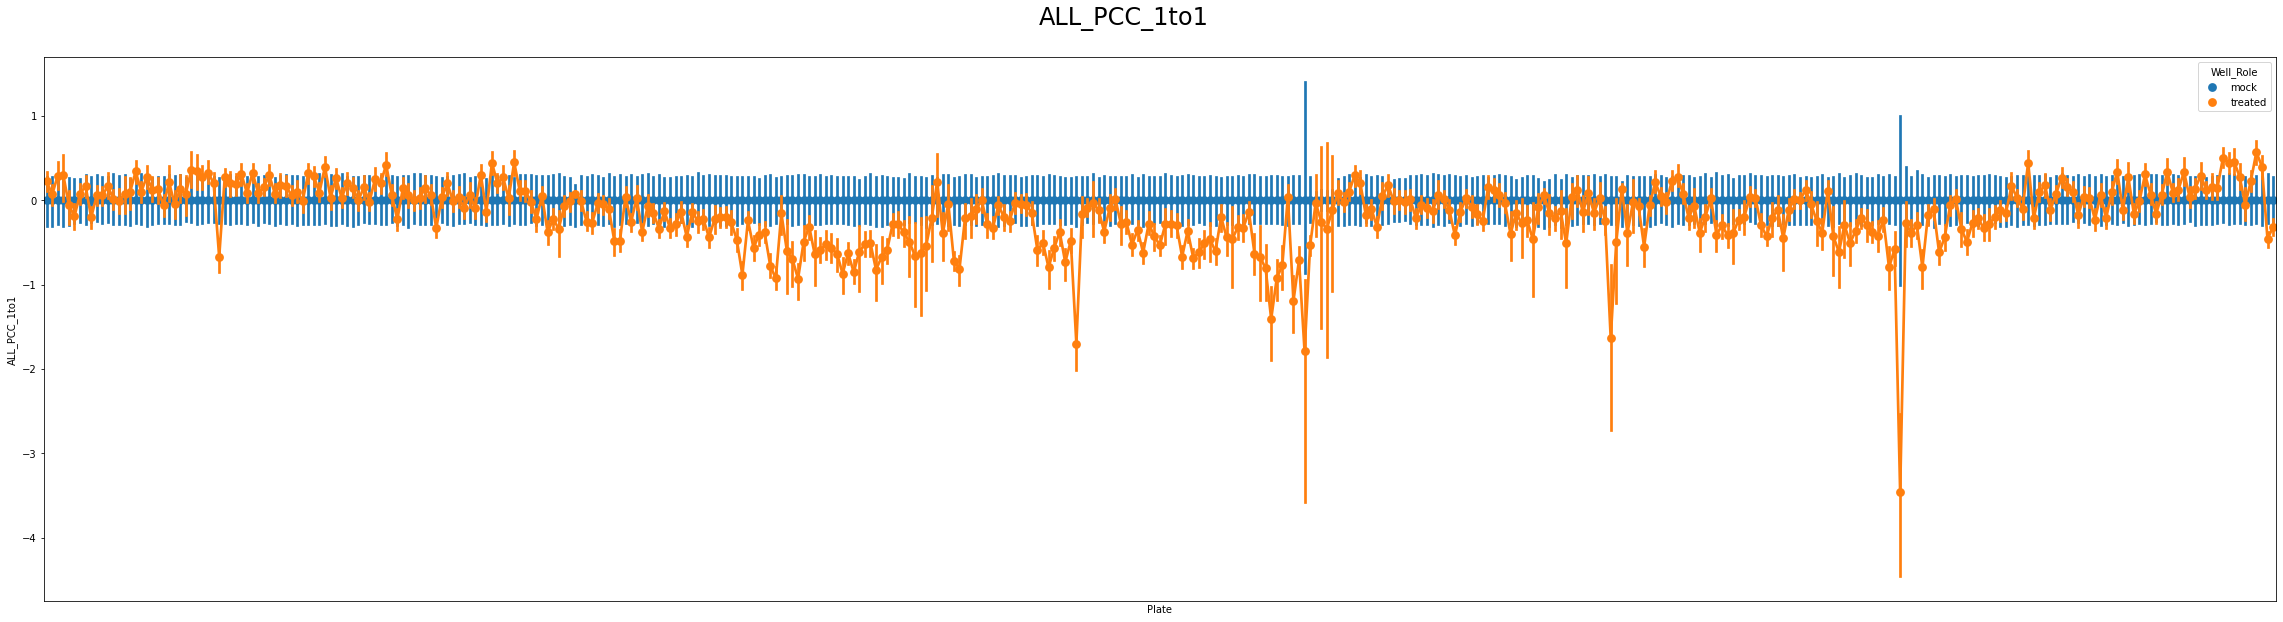

In [23]:
fig, ax = plt.subplots(figsize=(40,10), facecolor='white')
fig.suptitle(f'ALL_PCC_1to1', fontsize = 24, y = 0.95)
sns.pointplot(data=final_res.reset_index(), x='Plate', y='ALL_PCC_1to1', hue='Well_Role', ax=ax)
ax.tick_params(axis='x', labelrotation=90, bottom=False, labelbottom=False)

# ax.set_ylim(-0.3, 0.3)
#  ll = len(g.collections) plt.setp(g.collections[:ll/2], alpha=.3)
# g=sns.pointplot(x=0, y=1, data=df, dodge=True,plot_kws=dict(alpha=0.3))
# plt.setp(g.collections, alpha=.3) #for the markers
# plt.setp(g.lines, alpha=.3)